In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
import shutil
from tqdm import tqdm
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from IQA_metrics import table_of_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

/home/khoa-ys/Projects/Course/similarity_venv/lib/python3.8/site-packages/phasepack/tools.py:11: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  warnings.warn("""


In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/multi_classed_grouped_data")
products = os.listdir(data_path)

generate_table_of_score = False
if generate_table_of_score:
    for product in products:
        print(product)
        
        product_path = os.path.join(data_path, product)
        good_images_path = os.path.join(product_path, 'train')
        defect_images_path = os.path.join(product_path, 'test/defect')
        
        train_good_image_list, test_good_image_list, all_train_defect_image_list, all_test_defect_image_list = generate_train_test_set(product_path)
        train_dict = dict(zip(train_good_image_list + all_train_defect_image_list, [1]*len(train_good_image_list) + [0]*len(all_train_defect_image_list)))
        test_dict = dict(zip(test_good_image_list[1:] + all_test_defect_image_list, [1]*len(test_good_image_list[1:]) + [0]*len(all_test_defect_image_list)))
        test_image_path = test_good_image_list[0]
        model_image_dict = dict(zip([test_image_path], [1]))
    
        train_table_of_score = table_of_score(model_image_dict, train_dict)
        test_table_of_score = table_of_score(model_image_dict, test_dict)
    
        np.savetxt(os.path.join(root_path, ('result/' + product + '_train_table_of_score_2.csv')), train_table_of_score, delimiter=",")
        np.savetxt(os.path.join(root_path, ('result/' + product + '_test_table_of_score_2.csv')), test_table_of_score, delimiter=",")

#### Combine and analyze tables of score

In [3]:
all_train_table_of_score = np.array([])
all_test_table_of_score = np.array([])
#shape_list_1 = []

for product in products:
    print(product)
    train_table_of_score_1 = np.loadtxt(os.path.join(root_path, ('result/' + product + '_train_table_of_score.csv')), delimiter=",", dtype=np.float64)
    train_table_of_score_2 = np.loadtxt(os.path.join(root_path, ('result/' + product + '_train_table_of_score_2.csv')), delimiter=",", dtype=np.float64)
    test_table_of_score_1 = np.loadtxt(os.path.join(root_path, ('result/' + product + '_test_table_of_score.csv')), delimiter=",", dtype=np.float64)
    test_table_of_score_2 = np.loadtxt(os.path.join(root_path, ('result/' + product + '_test_table_of_score_2.csv')), delimiter=",", dtype=np.float64)

    #print(train_table_of_score_1.shape, train_table_of_score_2.shape)
    train_table_of_score = np.hstack((train_table_of_score_1[:,:-1], train_table_of_score_2))
    
    #print(test_table_of_score_1.shape, test_table_of_score_2.shape)
    test_table_of_score = np.hstack((test_table_of_score_1[:,:-1], test_table_of_score_2))

    if len(all_train_table_of_score) == 0 or len(all_test_table_of_score) == 0:
        all_train_table_of_score = train_table_of_score
        all_test_table_of_score = test_table_of_score
    #shape_list_1.append(train_table_of_score.shape)
    
    all_train_table_of_score = np.concatenate((all_train_table_of_score, train_table_of_score))
    all_test_table_of_score = np.concatenate((all_test_table_of_score, test_table_of_score))

# 'issm' always return 0, so we just gonna remove it
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_train_table_of_score

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper


,rmse,psnr,fsim,ssim,uiq,sam,sre,class
0,0.002991,50.323443,0.465997,0.991392,0.216821,88.602301,61.618167,1.0
1,0.003304,49.531086,0.403571,0.989306,0.172166,88.650093,61.110725,1.0
2,0.003618,48.793717,0.445561,0.988317,0.183132,88.610693,60.661319,1.0
3,0.003057,50.193015,0.442229,0.990670,0.190234,88.631530,61.459766,1.0
4,0.003383,49.334222,0.419190,0.989537,0.167303,88.594827,61.000213,1.0
...,...,...,...,...,...,...,...,...
8731,0.011513,38.778831,0.361109,0.860352,0.014230,0.000000,53.656258,0.0
8732,0.009521,40.428163,0.357161,0.924669,0.009342,88.800153,54.475749,0.0
8733,0.008606,41.306996,0.340899,0.957650,0.015121,88.186944,54.913751,0.0
8734,0.006561,43.663948,0.365115,0.964862,-0.003525,88.243292,56.092938,0.0


### Study correlation matrix:

<Axes: >

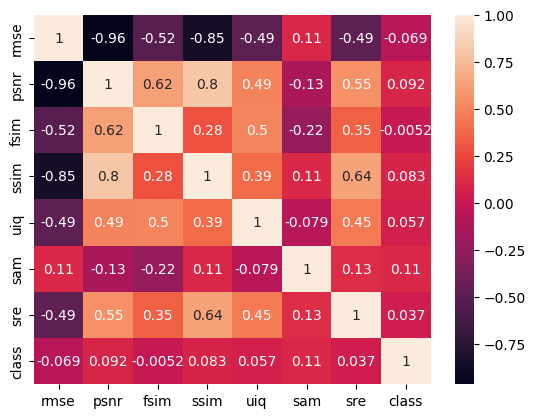

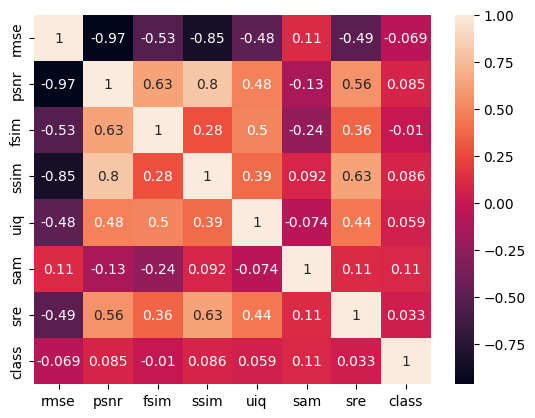

In [4]:
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])

train_corr_matrix = all_train_table_of_score.corr()
plt.figure()
sns.heatmap(train_corr_matrix, annot=True)

test_corr_matrix = all_test_table_of_score.corr()
plt.figure()
sns.heatmap(test_corr_matrix, annot=True)

### Fit basic discriminator

In [5]:
all_train_table_of_score = pd.DataFrame(all_train_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])
all_test_table_of_score = pd.DataFrame(all_test_table_of_score, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre', 'class'])

X_train, y_train = all_train_table_of_score[['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre']].to_numpy(), all_train_table_of_score['class'].to_numpy()
X_test, y_test = all_test_table_of_score[['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre']].to_numpy(), all_test_table_of_score['class'].to_numpy()

# Normalize X_train, X_test:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
pd.DataFrame(X_train, columns = ['rmse', 'psnr', 'fsim', 'ssim', 'uiq', 'sam', 'sre'])

,rmse,psnr,fsim,ssim,uiq,sam,sre
0,-0.810164,0.729375,-0.795998,-0.779924,-0.803622,1.900504,1.074933
1,-0.810154,0.705133,-0.797908,-0.779988,-0.804988,1.901966,1.059408
2,-0.810145,0.682573,-0.796623,-0.780018,-0.804652,1.900761,1.045659
3,-0.810162,0.725384,-0.796725,-0.779946,-0.804435,1.901398,1.070087
4,-0.810152,0.699110,-0.797430,-0.779981,-0.805137,1.900275,1.056027
...,...,...,...,...,...,...,...
8731,-0.809903,0.376171,-0.799207,-0.783933,-0.809820,-0.810255,0.831341
8732,-0.809964,0.426632,-0.799328,-0.781965,-0.809969,1.906557,0.856413
8733,-0.809992,0.453519,-0.799826,-0.780956,-0.809793,1.887796,0.869814
8734,-0.810055,0.525629,-0.799085,-0.780736,-0.810363,1.889520,0.905890


#### SVM

(array([0.]), array([2178]))
(array([0., 1.]), array([1321,  857]))
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76      1321
         1.0       1.00      0.00      0.00       857

    accuracy                           0.61      2178
   macro avg       0.80      0.50      0.38      2178
weighted avg       0.76      0.61      0.46      2178



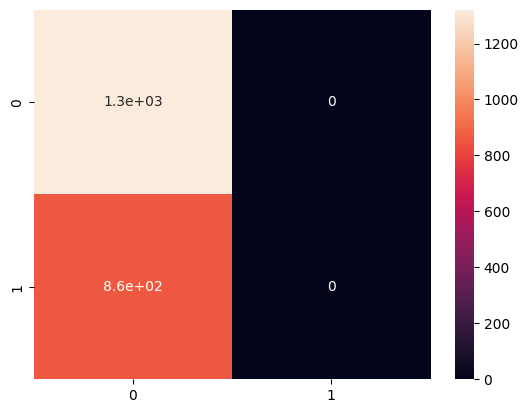

In [15]:
svc = SVC(kernel='rbf', gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(np.unique(y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, y_pred, zero_division=1))

#### RF

(array([0., 1.]), array([1942,  236]))
(array([0., 1.]), array([1321,  857]))
              precision    recall  f1-score   support

         0.0       0.65      0.95      0.77      1321
         1.0       0.71      0.20      0.31       857

    accuracy                           0.65      2178
   macro avg       0.68      0.57      0.54      2178
weighted avg       0.67      0.65      0.59      2178



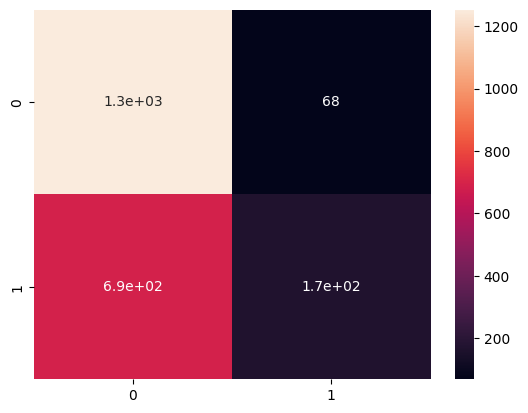

In [16]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(np.unique(y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, y_pred, zero_division=1))

#### Logit Regression

(array([0., 1.]), array([2020,  158]))
(array([0., 1.]), array([1321,  857]))
              precision    recall  f1-score   support

         0.0       0.62      0.95      0.75      1321
         1.0       0.61      0.11      0.19       857

    accuracy                           0.62      2178
   macro avg       0.62      0.53      0.47      2178
weighted avg       0.62      0.62      0.53      2178



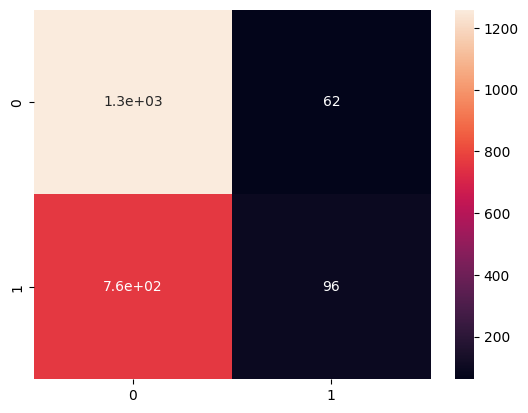

In [17]:
logit = LogisticRegression(random_state=0)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

print(np.unique(y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), annot=True)
print(classification_report(y_test, y_pred, zero_division=1))

In [9]:
learning_rate = 3e-4
batch_size = 256
epochs = 100
n_classes = len(np.unique(y_train))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, data, data_label):
        self.data = data
        self.data_label = data_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_i = self.data[idx]
        data_label_i = self.data_label[idx]
        
        return data_i, data_label_i

class SimpleMLP(torch.nn.Module):

    def __init__(self, n_class):
        super(SimpleMLP, self).__init__()
        self.mlp = torch.nn.Sequential(torch.nn.Linear(7, 2**3),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(2**3, n_class),)
                                       #torch.nn.Softmax(dim=1))

    def forward(self, x):
        x = self.mlp(x)
        return x

model = SimpleMLP(2).type(torch.float64)

In [11]:
train_dataset = BrainTumorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
loss_fn = nn.CrossEntropyLoss()
#params = [p for p in vgg19.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Epoch: 0 Training loss: 0.587118
Time elapsed: 0.6128880977630615
------------ Epoch: 1 ------------
Epoch: 1 Training loss: 0.581867
Time elapsed: 0.03253293037414551
------------ Epoch: 2 ------------
Epoch: 2 Training loss: 0.578164
Time elapsed: 0.03667306900024414
------------ Epoch: 3 ------------
Epoch: 3 Training loss: 0.575770
Time elapsed: 0.03589653968811035
------------ Epoch: 4 ------------
Epoch: 4 Training loss: 0.572386
Time elapsed: 0.036229610443115234
------------ Epoch: 5 ------------
Epoch: 5 Training loss: 0.571777
Time elapsed: 0.038521528244018555
------------ Epoch: 6 ------------
Epoch: 6 Training loss: 0.572364
Time elapsed: 0.037657976150512695
------------ Epoch: 7 ------------
Epoch: 7 Training loss: 0.572152
Time elapsed: 0.03237342834472656
------------ Epoch: 8 ------------
Epoch: 8 Training loss: 0.572470
Time elapsed: 0.03269600868225098
------------ Epoch: 9 ------------
Epoch: 9 Training loss: 0.570374
Time elapsed

Text(0.5, 0, 'Epoch')

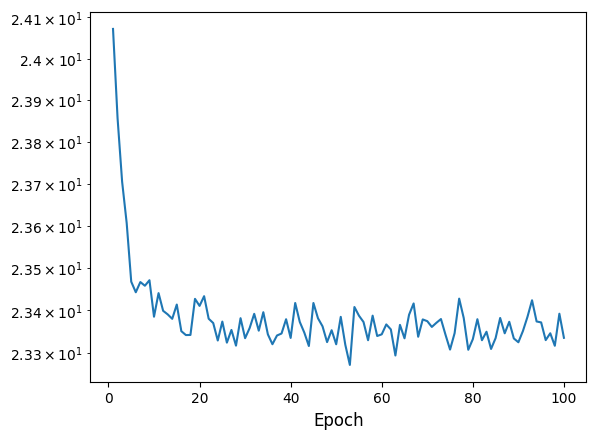

In [13]:
model.to(device)
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (train_X, train_y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(train_X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, train_y.type(torch.LongTensor).to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(train_X)
        #print(loss)
        training_loss += loss
    
    scheduler.step()
    print("Epoch:", epoch,f"Training loss: {training_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.yscale("log")
plt.xlabel('Epoch', fontsize=12)

(array([0]), array([2178]))
(array([0., 1.]), array([1321,  857]))
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76      1321
         1.0       1.00      0.00      0.00       857

    accuracy                           0.61      2178
   macro avg       0.80      0.50      0.38      2178
weighted avg       0.76      0.61      0.46      2178



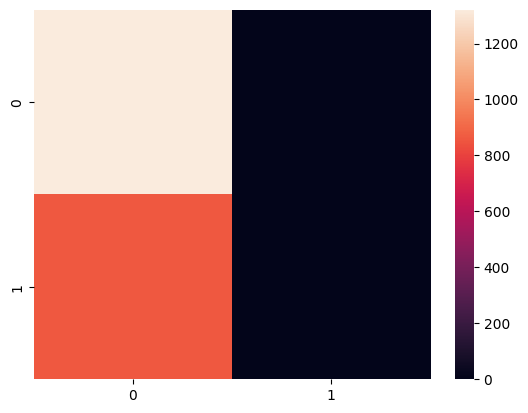

In [14]:
model.to('cpu')
predictions, true_labels = [], []
for batch, (test_X, test_y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(test_X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    true_labels += test_y.tolist()

print(np.unique(predictions, return_counts=True))
print(np.unique(true_labels, return_counts=True))
sns.heatmap(confusion_matrix(true_labels, predictions, labels=range(0, n_classes)))
print(classification_report(true_labels, predictions, zero_division=1))